In [2]:
import pandas as pd
import scipy
import scipy.stats as st
import numpy as np
from sklearn.metrics import precision_recall_curve, auc, roc_auc_score, average_precision_score, f1_score
from sklearn.model_selection import RepeatedKFold
import lightgbm as lgb
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [3]:
pinfo = pd.read_csv('./data/clinical.txt', index_col="PatientID",sep = "\t")
rna = pd.read_csv('./data/table.1-2.TPM.gene.by.Tumor.csv', index_col=0)
rna = rna[rna.columns[(rna==0).mean()<0.1]]
rna = (rna+0.01).applymap(np.log2)
rna.index = rna.index.str.replace('_T', '', regex=False)

In [4]:
pinfo['pCR'] = pinfo['pCR_consensus']

([], [])

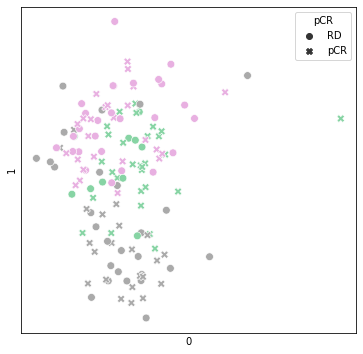

In [5]:
import numpy as np
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
rna_pca = pd.DataFrame(pca.fit_transform(rna))
rna_pca.index = rna.index
rna_pca['subtype'] = rna_pca.index.map(pinfo['HER2_Status'])+rna_pca.index.map(pinfo['ER_Status'])
rna_pca['pCR'] = rna_pca.index.map(pinfo['pCR'])

plt.subplots(figsize=[6,6])
sns.scatterplot(x=rna_pca[0],y=rna_pca[1],\
                c=rna_pca['subtype'].map({'PosPos':'#e8b0e1','PosNeg':'#87d4a4','NegNeg':'#aaaaaa'}),\
                style=rna_pca['pCR'], s=60)
plt.xticks([])
plt.yticks([])
# plt.savefig('rna_pca.png',dpi=600)

In [6]:
df = pd.merge(pinfo[['HER2_Status','ER_Status','pCR']], rna, left_index=True, right_index=True, how='inner')

In [7]:
import pandas as pd
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm

In [8]:
anova = {}

In [9]:
df_anova = df.copy()
# for i in rna.columns[(rna==np.log2(0.01)).mean()==0]:
#     df_anova[i.replace('.','_').replace('-','_')] = df[i]
#     formula = i.replace('.','_').replace('-','_')+' ~ HER2_Status + ER_Status + pCR + HER2_Status:ER_Status + HER2_Status:pCR + ER_Status:pCR + HER2_Status:ER_Status:pCR'
#     model = ols(formula, df_anova).fit()
#     anova[i] = anova_lm(model, typ=3)
    
# for i in rna.columns[(rna==np.log2(0.01)).mean()!=0]:
#     df_anova[i.replace('.','_').replace('-','_')] = df[i]
#     formula = i.replace('.','_').replace('-','_')+' ~ HER2_Status + ER_Status + pCR + HER2_Status:ER_Status + HER2_Status:pCR + ER_Status:pCR + HER2_Status:ER_Status:pCR'
#     model = ols(formula, df_anova.loc[df_anova[i]!=np.log2(0.01)]).fit()
#     anova[i] = anova_lm(model, typ=3)
    
for i in rna.columns:
    df_anova[i.replace('.','_').replace('-','_')] = df[i]
    formula = i.replace('.','_').replace('-','_')+' ~ HER2_Status + ER_Status + pCR + HER2_Status:ER_Status + HER2_Status:pCR + ER_Status:pCR + HER2_Status:ER_Status:pCR'
    model = ols(formula, df_anova).fit()
    anova[i] = anova_lm(model, typ=3) 

In [10]:
len(anova)

15788

In [11]:
anova_p = anova['A1BG'][[]]
for i in anova.keys():
    anova_p[i] = anova[i]['PR(>F)']

In [12]:
# import numpy as np

# f = 'HER2_Status'
# g = 'ERBB2'

# sns.displot(-anova_p.T[f].apply(np.log10), color='gray', height=3)
# sns.lineplot(x=[-anova_p.T[f].apply(np.log10)[g],-anova_p.T[f].apply(np.log10)[g]],\
#              y=[0,1000], color='red', estimator=None)
# hi = 500
# for i in anova_p.T[f][anova_p.T[f]<anova_p.T[f][g]].sort_values():
#     sns.lineplot(x=[-np.log10(i),-np.log10(i)],\
#                  y=[0,hi], color='red', estimator=None)
# #     hi+=100
# plt.xticks([0,5,10])
# plt.xlim([-0.5,11])

In [13]:
# import numpy as np

# f = 'ER_Status'
# g = 'ESR1'

# sns.displot(-anova_p.T[f].apply(np.log10), color='gray', height=3)
# sns.lineplot(x=[-anova_p.T[f].apply(np.log10)[g],-anova_p.T[f].apply(np.log10)[g]],\
#              y=[0,1000], color='red', estimator=None)
# hi = 500
# for i in anova_p.T[f][anova_p.T[f]<anova_p.T[f][g]].sort_values():
#     sns.lineplot(x=[-np.log10(i),-np.log10(i)],\
#                  y=[0,hi], color='red', estimator=None)
# #     hi+=100
# plt.xticks([0,5,10])
# plt.xlim([-0.5,11])

In [14]:
anova_p.T.sort_values('HER2_Status')[:10]

,Intercept,HER2_Status,ER_Status,pCR,HER2_Status:ER_Status,HER2_Status:pCR,ER_Status:pCR,HER2_Status:ER_Status:pCR,Residual
PGAP3,1.246193e-15,8.205315e-12,0.976532,0.852760,0.976532,0.224763,0.439956,0.439956,NaN
ERBB2,1.441269e-39,2.466369e-10,0.661725,0.614484,0.661725,0.018328,0.039831,0.039831,NaN
PNMT,1.182002e-07,5.654189e-08,0.047856,0.625690,0.047856,0.899406,0.825270,0.825270,NaN
MIEN1,5.721412e-26,7.145589e-08,0.541383,0.860435,0.541383,0.123923,0.228719,0.228719,NaN
GRB7,4.579614e-13,2.064446e-07,0.982203,0.961418,0.982203,0.410568,0.502502,0.502502,NaN
TCAP,1.719779e-13,4.860779e-07,0.532791,0.723360,0.532791,0.273000,0.305410,0.305410,NaN
STARD3,1.499333e-38,2.412798e-06,0.812019,0.932053,0.812019,0.223000,0.587755,0.587755,NaN
HID1,1.982047e-23,2.899413e-06,0.443671,0.830112,0.443671,0.321473,0.104686,0.104686,NaN
TFF3,1.412355e-01,3.319434e-06,0.169225,0.405581,0.169225,0.494177,0.660912,0.660912,NaN
CRISP3,4.951957e-06,2.728976e-05,0.007807,0.760647,0.007807,0.582760,0.221150,0.221150,NaN


In [15]:
anova_p.T.sort_values('ER_Status')[:10]

,Intercept,HER2_Status,ER_Status,pCR,HER2_Status:ER_Status,HER2_Status:pCR,ER_Status:pCR,HER2_Status:ER_Status:pCR,Residual
ESR1,1.586111e-06,0.889165,5.760754e-09,0.115038,5.760754e-09,0.999902,0.720514,0.720514,NaN
C5AR2,1.498077e-07,0.149730,8.733222e-09,0.340691,8.733222e-09,0.068320,0.040408,0.040408,NaN
SUSD3,2.223774e-02,0.453243,2.005522e-05,0.520688,2.005522e-05,0.790851,0.934101,0.934101,NaN
NAT1,3.820585e-01,0.412743,2.488375e-05,0.720271,2.488375e-05,0.817201,0.750656,0.750656,NaN
ARMT1,5.861936e-19,0.470893,3.766011e-05,0.879849,3.766011e-05,0.886229,0.562277,0.562277,NaN
IL22RA2,6.834127e-13,0.587591,3.800165e-05,0.671317,3.800165e-05,0.782216,0.168658,0.168658,NaN
GREB1,1.101615e-02,0.752101,4.956360e-05,0.056472,4.956360e-05,0.426755,0.810534,0.810534,NaN
ADGRF1,9.434223e-06,0.028091,5.484672e-05,0.765911,5.484672e-05,0.079708,0.036120,0.036120,NaN
CCDC170,4.518929e-01,0.805426,5.711025e-05,0.347449,5.711025e-05,0.963927,0.862081,0.862081,NaN
RMND1,1.689753e-30,0.753521,6.762960e-05,0.941760,6.762960e-05,0.417547,0.412659,0.412659,NaN


In [16]:
anova_p.T.sort_values('pCR')[:10]

,Intercept,HER2_Status,ER_Status,pCR,HER2_Status:ER_Status,HER2_Status:pCR,ER_Status:pCR,HER2_Status:ER_Status:pCR,Residual
FAT3,1.826588e-05,0.809731,0.882093,0.000347,0.882093,0.130081,0.982736,0.982736,NaN
UCN,3.993529e-07,0.095338,0.635745,0.000348,0.635745,0.066463,0.811883,0.811883,NaN
CCL18,4.184837e-01,0.226574,0.361162,0.000359,0.361162,0.331853,0.633272,0.633272,NaN
RUNDC3A,1.980642e-15,0.130789,0.693826,0.000487,0.693826,0.013879,0.812293,0.812293,NaN
TFDP1,2.085072e-50,0.316352,0.776044,0.000643,0.776044,0.037232,0.353297,0.353297,NaN
DEK,7.808063e-62,0.149493,0.779088,0.000880,0.779088,0.003047,0.107723,0.107723,NaN
CMYA5,3.241155e-05,0.603559,0.295751,0.000922,0.295751,0.667786,0.083818,0.083818,NaN
ADD2,4.001883e-04,0.552928,0.348211,0.001137,0.348211,0.001933,0.177013,0.177013,NaN
AR,2.078284e-06,0.002165,0.636153,0.001182,0.636153,0.025113,0.873946,0.873946,NaN
QPCT,7.723856e-05,0.640603,0.474299,0.001184,0.474299,0.015809,0.540492,0.540492,NaN


In [17]:
anova_p.T.sort_values('HER2_Status:ER_Status:pCR')[:10]

,Intercept,HER2_Status,ER_Status,pCR,HER2_Status:ER_Status,HER2_Status:pCR,ER_Status:pCR,HER2_Status:ER_Status:pCR,Residual
STOX2,2.971446e-05,0.848094,0.000821,0.443501,0.000821,0.000028,0.000057,0.000057,NaN
LIPT2,7.532163e-05,0.054515,0.013729,0.225097,0.013729,0.000376,0.000081,0.000081,NaN
CENPV,2.165454e-22,0.905175,0.011927,0.611005,0.011927,0.005827,0.000274,0.000274,NaN
GABRB3,4.498551e-09,0.023067,0.014153,0.545347,0.014153,0.039424,0.000502,0.000502,NaN
FBXO25,3.355165e-23,0.559422,0.068766,0.459003,0.068766,0.006486,0.000528,0.000528,NaN
AGBL3,8.471894e-01,0.233767,0.053294,0.735884,0.053294,0.006903,0.001085,0.001085,NaN
PSMD8,3.217515e-60,0.000332,0.001071,0.392933,0.001071,0.001700,0.001101,0.001101,NaN
ZNF582,1.101139e-02,0.002668,0.019240,0.984704,0.019240,0.006912,0.001229,0.001229,NaN
ZNF391,6.296748e-03,0.934772,0.027633,0.358679,0.027633,0.079207,0.001552,0.001552,NaN
C4orf19,2.809476e-02,0.490617,0.092162,0.913322,0.092162,0.006459,0.001646,0.001646,NaN


437


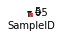

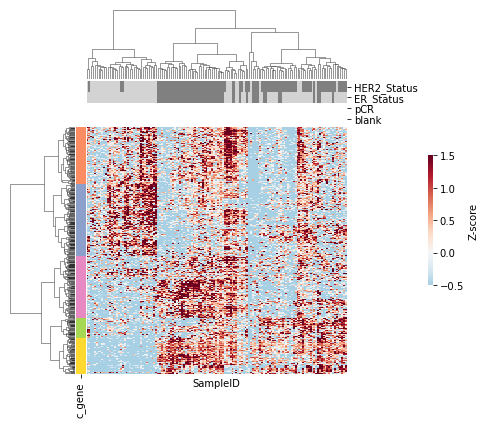

In [21]:
topN = 100
glist = []+\
        list(anova_p.T.sort_values('HER2_Status:ER_Status:pCR')[:topN].index)+\
        list(anova_p.T.sort_values('HER2_Status:pCR')[:topN].index)+\
        list(anova_p.T.sort_values('ER_Status:pCR')[:topN].index)+\
        list(anova_p.T.sort_values('HER2_Status:ER_Status')[:topN].index)+\
        list(anova_p.T.sort_values('pCR')[:topN].index)+\
        list(anova_p.T.sort_values('HER2_Status')[:topN].index)+\
        list(anova_p.T.sort_values('ER_Status')[:topN].index)

glist = sorted(set(glist))
print(len(glist))
df_toshow = rna[glist].apply(st.zscore)
# df_toshow.T.to_csv('./rna_anova100.csv')
# df_toshow['cluster'] = df_toshow.index.map(patient_cluster['x']).map(lut_c)
df_toshow['HER2_Status'] = df_toshow.index.map(pinfo['HER2_Status']).map({'Neg':'lightgray','Pos':'gray'})
df_toshow['ER_Status'] = df_toshow.index.map(pinfo['ER_Status']).map({'Neg':'lightgray','Pos':'gray'})
df_toshow['pCR'] = df_toshow.index.map(pinfo['pCR']).map({1:'lightblue',0:'#ff7878'})
df_toshow['blank'] = df_toshow.index.map(pinfo['pCR']).map({1:'white',0:'white'})
# snv = (pd.read_csv('../../masked/snv.csv', index_col=0)>1)*1
# df_toshow['TP53_mut'] = df_toshow.index.map(snv['TP53']).map({1:'gray',0:'lightgray'}).fillna('white')
# df_toshow['PIK3CA_mut'] = df_toshow.index.map(snv['PIK3CA']).map({1:'gray',0:'lightgray'}).fillna('white')
# df_toshow['GATA3_mut'] = df_toshow.index.map(snv['GATA3']).map({1:'gray',0:'lightgray'}).fillna('white')


lut_c = {}
for i in range(7):
    lut_c[i] = sns.color_palette("Set2")[i]
clm = sns.clustermap(df_toshow[glist].T, method='ward', figsize=[0.1,0.1])                    
gene_color = df_toshow[glist].T[[]]
gene_color['c_gene'] = scipy.cluster.hierarchy.fcluster(clm.dendrogram_row.linkage, t=5, criterion='maxclust')
gene_color['c_gene'] = gene_color['c_gene'].map(lut_c)
# df['c_sample'] = scipy.cluster.hierarchy.fcluster(clm.dendrogram_col.linkage, t=6, criterion='maxclust')
# df['c_sample'] = df['c_sample'].map(lut_c)


sns.clustermap(df_toshow[glist].T,\
               col_colors=df_toshow[['HER2_Status','ER_Status','pCR','blank',]],\
                     row_colors=gene_color['c_gene'],\
               xticklabels=False,yticklabels=False,\
              row_cluster=True, col_cluster=True,method='ward',\
               vmin=-.5, center=0., vmax=1.5,\
                     figsize=[6,6],cbar_pos=(1, 0.33, .01, .3),cbar_kws={'label': 'Z-score'},cmap='RdBu_r' )

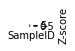

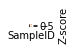

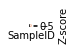

In [22]:
df_sub = {}

for i in [1,2,3]:
    df_sub[i] = df_toshow.copy()
    df_sub[i]['cluster'] = scipy.cluster.hierarchy.fcluster(clm.dendrogram_col.linkage, t=3, criterion='maxclust')
    df_sub[i] = df_sub[i][df_sub[i]['cluster']==i]

    clm_sub = sns.clustermap(df_sub[i][glist].T,\
                  row_cluster=True, col_cluster=True,method='ward',metric='euclidean',\
                         figsize=[.06,.06],cbar_pos=(1, 0.33, .01, .3),cbar_kws={'label': 'Z-score'},cmap='RdBu_r' )
    df_sub[i]['cluster_sub'] = scipy.cluster.hierarchy.fcluster(clm_sub.dendrogram_col.linkage, t=2, criterion='maxclust')
    df_sub[i]['cluster_sub'] = df_sub[i]['cluster'].astype(str) + df_sub[i]['cluster_sub'].astype(str)

In [23]:
topN = 100
glist = []+\
        list(anova_p.T.sort_values('HER2_Status:ER_Status:pCR')[:topN].index)+\
        list(anova_p.T.sort_values('HER2_Status:pCR')[:topN].index)+\
        list(anova_p.T.sort_values('ER_Status:pCR')[:topN].index)+\
        list(anova_p.T.sort_values('HER2_Status:ER_Status')[:topN].index)+\
        list(anova_p.T.sort_values('pCR')[:topN].index)+\
        list(anova_p.T.sort_values('HER2_Status')[:topN].index)+\
        list(anova_p.T.sort_values('ER_Status')[:topN].index)

glist = sorted(set(glist))
print(len(glist))
df_toshow = rna[glist].apply(st.zscore)
df_toshow.T.to_csv('./rna_anova100.csv')
# df_toshow['cluster'] = df_toshow.index.map(patient_cluster['x']).map(lut_c)
df_toshow['HER2_Status'] = df_toshow.index.map(pinfo['HER2_Status']).map({'Neg':'lightgray','Pos':'gray'})
df_toshow['ER_Status'] = df_toshow.index.map(pinfo['ER_Status']).map({'Neg':'lightgray','Pos':'gray'})
df_toshow['pCR'] = df_toshow.index.map(pinfo['pCR']).map({1:'lightblue',0:'#ff7878'})
# df_toshow['blank'] = df_toshow.index.map(pinfo['pCR']).map({1:'white',0:'white'})
snv = (pd.read_csv('./data/table.1-1.snv.mask.csv', index_col=0)>1)*1
df_toshow['TP53_mut'] = df_toshow.index.map(snv['TP53']).map({1:'gray',0:'lightgray'}).fillna('white')
df_toshow['PIK3CA_mut'] = df_toshow.index.map(snv['PIK3CA']).map({1:'gray',0:'lightgray'}).fillna('white')
df_toshow['GATA3_mut'] = df_toshow.index.map(snv['GATA3']).map({1:'gray',0:'lightgray'}).fillna('white')
df_toshow

437


,ABCC11,ABCC5,ABHD1,ABI2,AC092042.3,AC098588.2,ACOT1,ACSBG1,ACTN2,ACTN4,...,ZNF608,ZNF658,ZNF773,ZNF879,HER2_Status,ER_Status,pCR,TP53_mut,PIK3CA_mut,GATA3_mut
SampleID,,,,,,,,,,,,,,,,,,,,,
PS001,-0.259028,-1.015570,1.848244,0.368555,0.161558,-1.129724,2.790250,-0.117804,-0.459965,-0.210669,...,0.920888,1.001531,0.136454,0.625717,gray,lightgray,NaN,lightgray,lightgray,lightgray
PS002,0.472395,0.771577,0.857868,1.613250,1.113836,1.117476,0.353830,0.646707,0.764947,1.388213,...,1.266612,1.187367,2.504853,1.787127,lightgray,lightgray,NaN,gray,gray,lightgray
PS003,0.060560,0.081473,-1.125853,-1.176803,-0.087805,-0.356217,-0.776676,-0.752075,-0.205258,-0.950052,...,-1.024589,-1.425513,-0.625808,-1.731650,gray,gray,NaN,white,white,white
PS004,-1.647183,-1.442225,0.620257,0.099817,0.929398,-0.356217,1.579934,-0.752075,0.272907,0.500905,...,1.209091,0.961914,-0.392621,-0.267662,lightgray,lightgray,NaN,lightgray,lightgray,lightgray
PS006,-0.574857,-0.097866,0.839712,-0.043604,0.874051,0.159748,1.249576,-1.226313,-0.012371,0.021913,...,0.856913,-0.132314,0.186051,0.155049,gray,lightgray,NaN,gray,lightgray,lightgray
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
PS145,-1.279474,0.238021,-0.813300,-0.931908,0.301346,-0.541212,-0.802702,-0.752075,-0.135664,-1.446847,...,-0.839055,-0.724877,0.179056,-1.443705,lightgray,lightgray,NaN,gray,lightgray,lightgray
PS146,-1.522335,-0.829850,0.553015,-1.176803,-0.957468,-0.642580,-0.479666,4.679764,-0.566767,1.708408,...,0.450711,0.240715,-1.036849,-0.697101,lightgray,lightgray,NaN,gray,lightgray,lightgray
PS147,0.492708,0.112169,-2.406364,-0.985994,-0.245841,-0.867341,-0.802702,0.921090,-0.135664,-0.176426,...,-0.663942,-0.336265,0.040222,1.467902,gray,gray,NaN,gray,lightgray,lightgray


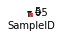

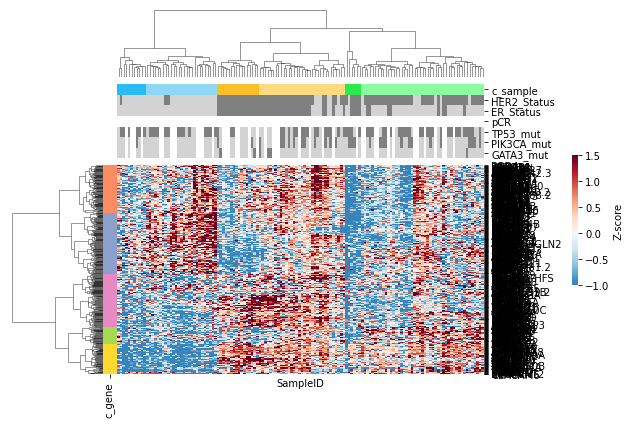

In [24]:
lut_c = {}
for i in range(7):
    lut_c[i] = sns.color_palette("Set2")[i]
clm = sns.clustermap(df_toshow[glist].T, method='ward', metric='euclidean',figsize=[0.1,0.1])       # correlation              
gene_color = df_toshow[glist].T[[]]
gene_color['c_gene'] = scipy.cluster.hierarchy.fcluster(clm.dendrogram_row.linkage, t=5, criterion='maxclust')
gene_color['c_gene'] = gene_color['c_gene'].map(lut_c)


# df['c_sample'] = scipy.cluster.hierarchy.fcluster(clm.dendrogram_col.linkage, t=6, criterion='maxclust')
df_toshow['c_sample'] = df_toshow.index.map(pd.concat([df_sub[1][['cluster_sub']],df_sub[2][['cluster_sub']],df_sub[3][['cluster_sub']]])['cluster_sub'])
df_toshow['c_sample'] = df_toshow['c_sample'].map({'11':'#2abbf5','12':'#8ed8f5','21':'#fabe28','22':'#ffdb80','31':'#2ce84f','32':'#8bfca0'})


clustermap = sns.clustermap(df_toshow[glist].T,\
               col_colors=df_toshow[['c_sample','HER2_Status','ER_Status','pCR','TP53_mut','PIK3CA_mut','GATA3_mut']],\
                     row_colors=gene_color['c_gene'],\
               xticklabels=False,yticklabels=True,\
              row_cluster=True, col_cluster=True,method='ward',metric='euclidean',\
               vmin=-1., center=0, vmax=1.5,\
                     figsize=[8,6],cbar_pos=(1, 0.33, .01, .3),cbar_kws={'label': 'Z-score'},cmap='RdBu_r' )
# plt.savefig('rna.100.png',dpi=600)
# plt.savefig('rna.100.pdf', format='pdf', bbox_inches='tight')
plt.savefig('Figure.4B.pdf', format='pdf', bbox_inches='tight')

In [25]:
df_toshow.to_csv("Figure.4B.RNA_clustering.df_toshow.csv")

In [26]:
from scipy.cluster.hierarchy import fcluster

# Get the reordered row indices
dataframeUSE = df_toshow[glist].T
# print(dataframeUSE)

reordered_indices = clustermap.dendrogram_row.reordered_ind

linkage_matrix_row = clustermap.dendrogram_row.linkage
linkage_matrix_col = clustermap.dendrogram_col.linkage

num_clusters = 5
clusters = fcluster(linkage_matrix_row, num_clusters, criterion='maxclust')
clusters_col = fcluster(linkage_matrix_col, num_clusters, criterion='maxclust')

results = []
for i, index in enumerate(clustermap.dendrogram_row.reordered_ind):
    row_name = dataframeUSE.index[index]
    cluster = clusters[i]
    results.append({'Row Name': row_name, 'Cluster': cluster})

# Create a DataFrame from the results
results_df = pd.DataFrame(results)

# Save the results to a CSV file
results_df.to_csv('RNA_clustered_rows.csv', index=False)


results2 = []
for i, index in enumerate(clustermap.dendrogram_col.reordered_ind):
    row_name = dataframeUSE.index[index]
    cluster = clusters[i]
    results.append({'Row Name': row_name, 'Cluster': cluster})

# Create a DataFrame from the results
results_df = pd.DataFrame(results)

# Save the results to a CSV file
results_df.to_csv('RNA_clustered_rows.csv', index=False)


In [27]:
# Get the reordered indices
reordered_indices = clustermap.dendrogram_row.reordered_ind
reordered_col_indices = clustermap.dendrogram_col.reordered_ind

# Create a reordered DataFrame
reordered_dataframe = dataframeUSE.iloc[reordered_indices,reordered_col_indices]

# Add cluster information to the reordered DataFrame
reordered_dataframe['Cluster'] = clusters

# Save the reordered DataFrame to a CSV file
reordered_dataframe.to_csv('RNA_reordered_dataframe.csv', index=True)